Logistic Regression
===


We will work with the dataset of the list of admision to a master degree in UCLA

In [1]:
import pandas as pd
url = "https://stats.idre.ucla.edu/stat/data/binary.csv"
df = pd.read_csv(url)


We can see that...
==
Here you need to describe the dataset: how many samples? do we have categorical features? Review the ranks of your variables




Preprocessing
==
Here you need to prepare your data for the model. Handle the categorical variables, separate your target and feature columns and split your dataset in testing and training.

Logistic model with Sklearn
==
First we train our model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train, y_train)



              precision    recall  f1-score   support

           0       0.69      0.91      0.78        53
           1       0.50      0.19      0.27        27

    accuracy                           0.66        80
   macro avg       0.59      0.55      0.53        80
weighted avg       0.62      0.66      0.61        80



Now we can classify our testing samples
==

In [ ]:
y_pred = model.predict(X_test)

#now let's see the metrics to see how well our model performed
print(classification_report(y_test, y_pred))

Interpreting the Logistic Regression Model
==

Beyond measuring performance, it is important to understand how each feature influences the model's predictions. In logistic regression, the model coefficients represent the effect of each feature on the log-odds of the outcome. By exponentiating these coefficients, we obtain the **odds ratios**, which provide a more intuitive interpretation: values greater than 1 increase the likelihood of the positive class, while values less than 1 decrease it.


  Feature  Odds Ratio
1     gpa    2.349584
0     gre    1.001798
2  rank_2    0.667927
4  rank_4    0.310152
3  rank_3    0.280679


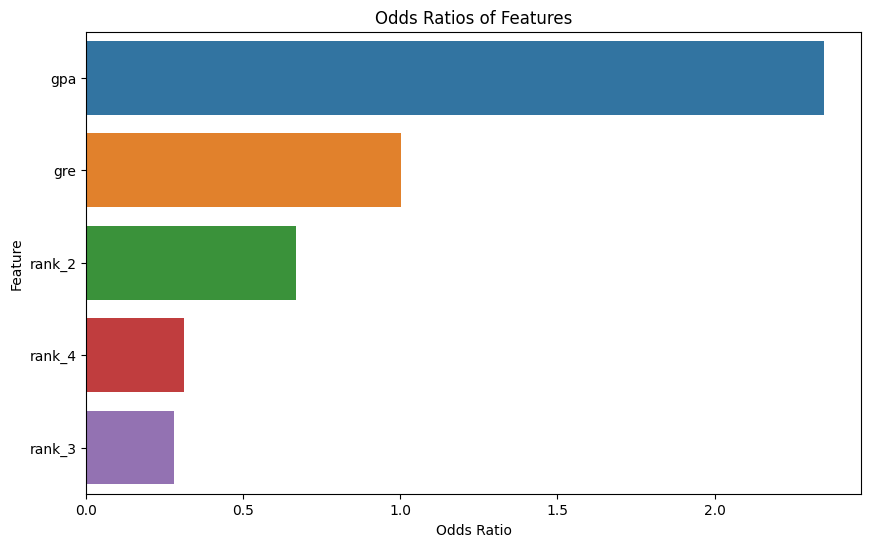

In [58]:
import numpy as np

odds_ratios = np.exp(model.coef_[0])
odds_ratios_df = pd.DataFrame({
    'Feature': X.columns,
    'Odds Ratio': odds_ratios
})
odds_ratios_df = odds_ratios_df.sort_values(by='Odds Ratio', ascending=False)
print(odds_ratios_df)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Odds Ratio', y='Feature', data=odds_ratios_df)
plt.title('Odds Ratios of Features')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.show()



Write your interpretation of the graph of the previous step

SHAP
==
We will analyze the relationship between the variables and their contribution to the final outcome using SHAP.

In [ ]:
feature_names = ["gre", "gpa", "rank_2", "rank_3", "rank_4"]

# we need to have our features as DataFrames
import pandas as pd
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


In [ ]:
import shap

#Create the explainer using the model and the data.
explainer = shap.Explainer(model, X_train)

# Get SHAP values for the test set
shap_values = explainer(X_test)


Summary
==
Let's visualize the impact of each feature on the model's prediction. The SHAP value tells us how much each feature contributed positively or negatively to the prediction. THis allows us to visualize which features drive the model's output the most and in what direction.

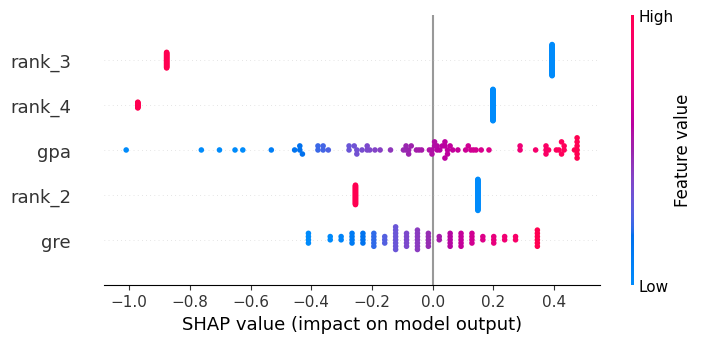

In [62]:
shap.plots.beeswarm(shap_values)



Dependence with a specific feature

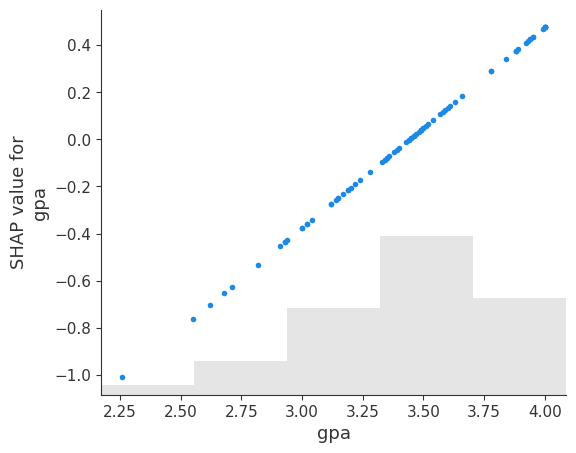

In [37]:
shap.plots.scatter(shap_values[:, "gpa"])


We can analyze a single prediction with the SHAP index. This plot is useful to understand why the model gave a specific prediction and which variables had the most influence. With red arrow we can see the features that increase the prediction value (they push it to the right, they increase the probability of admission in this case). With blue arrows the features that decrease the prediction (they push it to the left). The size of the arrow reflects the magnitude of that feature's contribution. 

In [41]:
shap.initjs()
shap.plots.force(shap_values[0])




Likelihood Estimation in Logistic Regression
===

We can do  the same as sklearn but with an implementation from scratch. This allows us to better understant this model.  

In [ ]:
import numpy as np

import numpy as np

# This function defines the sigmoid activation, which maps any real number to a value between 0 and 1.
def sigmoid(z):
    # Ensure the input is a NumPy array of type float64 for precision.
    z = np.array(z, dtype=np.float64)

    # Clip values to avoid numerical overflow in exp(-z) for very large/small inputs.
    # For instance, exp(-1000) or exp(1000) can result in numerical instability or 'inf'.
    z = np.clip(z, -500, 500)

    # Compute the sigmoid function element-wise: 1 / (1 + exp(-z))
    return 1 / (1 + np.exp(-z))


# This function computes the negative log-likelihood, which we want to minimize.
# It's the cost function for logistic regression.
def neg_log_likelihood(beta, X, y):
    # Ensure beta is a NumPy array with float64 precision.
    beta = np.array(beta, dtype=np.float64)

    # If beta is a 1D array, reshape it into a column vector (n_features, 1)
    if beta.ndim == 1:
        beta = beta.reshape(-1, 1)

    # Compute the linear combination z = X * beta
    z = X.dot(beta)

    # Apply sigmoid to get predicted probabilities p
    p = sigmoid(z)

    # Add a small constant epsilon to avoid computing log(0), which is undefined.
    epsilon = 1e-5

    # Compute the negative log-likelihood:
    # -[ y * log(p) + (1 - y) * log(1 - p) ]
    # This is the objective function to minimize in logistic regression.
    return -np.sum(y * np.log(p + epsilon) + (1 - y) * np.log(1 - p + epsilon))


# ----------------------------------------------------------
# Prepare the data for optimization
# ----------------------------------------------------------

# Add a column of ones to X for the intercept term (bias)
# X has shape (n_samples, n_features), so we stack a (n_samples, 1) column of ones
# This allows us to treat the intercept as just another coefficient
X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X.values])

# ----------------------------------------------------------
# Optimization step using scipy
# ----------------------------------------------------------

from scipy.optimize import minimize

# Initialize beta as a zero vector. Its length is (n_features + 1) to include the intercept.
initial_beta = np.zeros(X_with_intercept.shape[1])

# Minimize the negative log-likelihood using the BFGS optimization algorithm.
# - Function to minimize: neg_log_likelihood
# - Initial guess: initial_beta
# - Arguments passed to the function: (X_with_intercept, y)
# - BFGS is a quasi-Newton method suitable for smooth functions
result = minimize(neg_log_likelihood, initial_beta, args=(X_with_intercept, y.values), method='BFGS')

# Extract the optimized beta coefficients from the result
beta_hat = result.x



Now we calculate our predicted probabilities:

In [28]:
y_pred_prob = sigmoid(X_with_intercept @ beta_hat)

And let's evaluate the model's performance

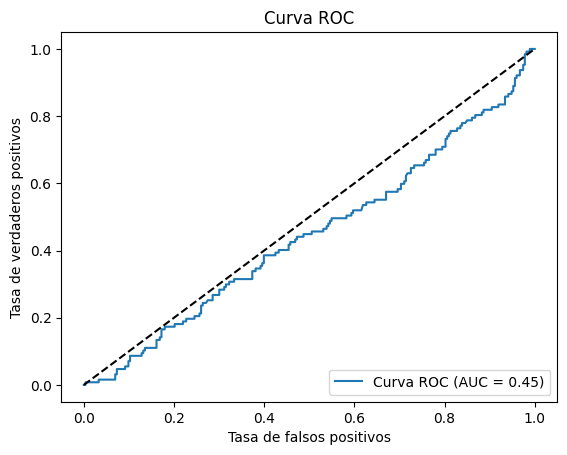

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
